In [195]:
from skimage.io import imread
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time


In [196]:
rootfolder = '../'

IRLS Algorithm
--------------
Define the problem parameters


In [197]:
A = np.array([[1, 3], [3, 1]]) # low dimensions to plot it, you can test larger sizes
b = np.array([-1, 2])

lmbda = 0.5


The function to be minimized is $\frac{1}{2}\|Ax-b\|_2^2 + \lambda \|x\|_1$

In [198]:
f = lambda x: 0.5 * np.sum((A @ x - b) ** 2) + lmbda * np.sum(np.abs(x))

# derivative of f from matrix calculus
df = lambda x: A.T @ (A @ x) - A.T @ b


Plot the function

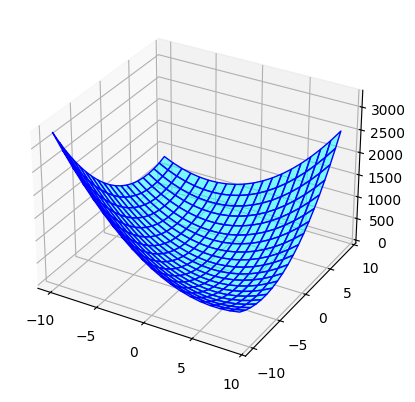

In [199]:
# this function has been prepared only for the visualization sake, no need to go through this but it renders some nice
# graphics :)
F = lambda r1, r2: (r1 * A[0, 0] + r2 * A[0, 1] - b[0]) ** 2 + (r1 * A[1, 0] + r2 * A[1,1] - b[1]) ** 2 + lmbda * (np.abs(r1) + np.abs(r2))
xx, yy = np.meshgrid(np.arange(-10, 10, 1), np.arange(-10, 10, 1))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, F(xx, yy), edgecolor=[0, 0, 1], alpha=0.5, facecolor=[0, 1, 1])

Set the parameters

In [200]:
MAX_ITER = 1e3
TOL_DIST_X = 1e-10

Initialization: test different inizializations, the function is convex, you always converge to the same solution

In [201]:
x0 = np.array([5, -10])

# initialization
all_x = [x0]
distanceX = 1e10  # stopping criteria
cnt = 0
delta = 1e-6

Main loop

In [202]:
while cnt < MAX_ITER and distanceX > TOL_DIST_X:
    x = all_x[-1]

    # compute the weight matrix
    W = np.diag(1 / np.abs(x) + delta)

    # solve the weighted regularized LS system
    x_current = np.linalg.solve(A.T @ A + lmbda * W, A.T @ b)

    distanceX = np.linalg.norm(x_current - x)

    # store the estimate
    # update all_x
    all_x.append(x_current)

    cnt = cnt + 1

Plot all the estimates

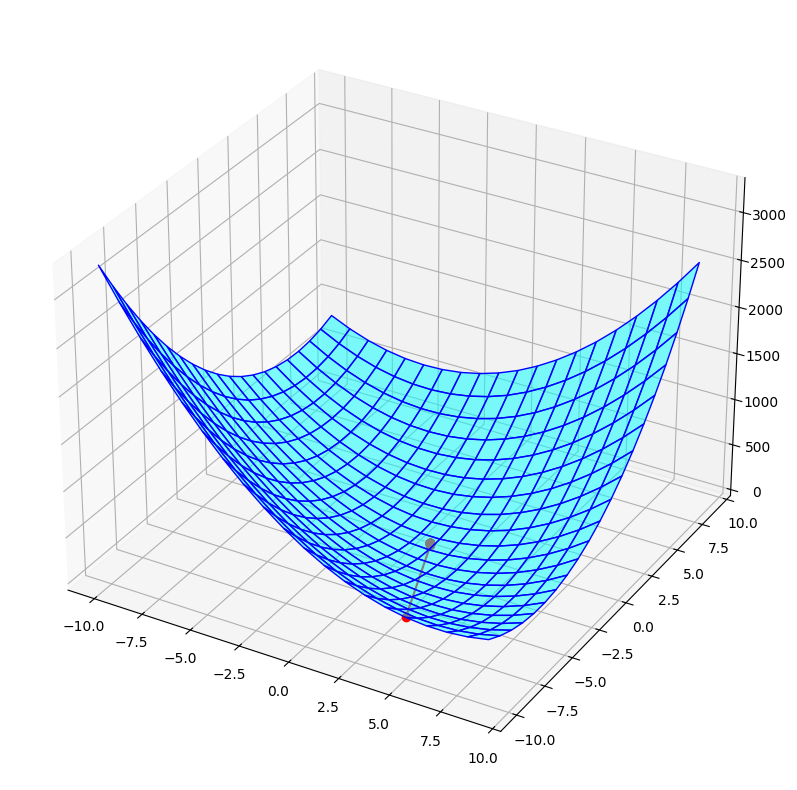

In [203]:
# plot the new estimate
xxplot = [x[0] for x in all_x]
yyplot = [x[1] for x in all_x]
zzplot = F(np.array(xxplot), np.array(yyplot))

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, F(xx, yy), edgecolor=[0, 0, 1], alpha=0.5, facecolor=[0, 1, 1])
ax.plot3D(xxplot, yyplot, zzplot, 'r-o')

In [204]:
print(f'nr of iteration of IRLS (before stopping criteria met): {cnt}\n')
print(f'Solution of IRLS: [{x_current[0]:.4f}, {x_current[1]:.4f}]\n')
print(f'Value of the functional: {f(x_current):.4f}\n')


nr of iteration of IRLS (before stopping criteria met): 14

Solution of IRLS: [0.7500, -0.5000]

Value of the functional: 0.6875



**THIS WAS NOT PRESENTED IN THE 2025 EDITION**: MOD dictionary learning
-----------------------
Useful function for plot the 2D DCT dictionary

In [205]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function to perform the sparse coding using your favorite algorithm (IRLS, FISTA or ISTA)

In [206]:
def IRLS(s, D, lmbda, x0=None, max_iter=10):
    """
    IRLS algorithm for sparse coding
    
    Args:
        s: input signal (can be 1D or 2D)
        D: dictionary matrix
        lmbda: regularization parameter
        x0: initial guess for coefficients
        max_iter: maximum number of iterations
    """
    delta = 1e-6
    
    # Ensure s is flattened
    s_flat = s.flatten() if s.ndim > 1 else s
    
    if x0 is None:
        x0 = np.zeros(D.shape[1])
    
    x = x0.copy()
    
    for _ in range(max_iter):
        # Compute weights with regularization to avoid division by zero
        weights = 1 / (np.abs(x) + delta)
        W = np.diag(weights)
        
        # Solve the weighted least squares problem
        # (D^T D + lambda * W) x = D^T s
        try:
            x = np.linalg.solve(D.T @ D + lmbda * W, D.T @ s_flat)
        except np.linalg.LinAlgError:
            # Fallback to pseudo-inverse if singular
            A = D.T @ D + lmbda * W
            x = np.linalg.pinv(A) @ (D.T @ s_flat)
    
    return x

Load the image and rescale it in [0,1]

In [207]:
img = imread(f'{rootfolder}/data/barbara.png') / 255
imsz = img.shape


Set the parameters

In [208]:
# patch size
p = 8

# number of elements in the patchfrom skimage.io import imread
M = p ** 2

# number of columns in the dictionary
N = 96

# extract the random patches from the noisy image
npatch = 1000

# only few MOD iterations are needed for a good dictionary
max_iter = 10

lmbda = 0.1

Extract $npatch$ random patches from the image


In [209]:
S = np.zeros((M, npatch))

for i in range(S.shape[1]):
    i_row = np.random.randint(0, img.shape[0] - p + 1)
    i_col = np.random.randint(0, img.shape[1] - p + 1)
    patch = img[i_row:i_row+p, i_col:i_col+p]
    S[:, i] = patch.flatten()

S = S - np.mean(S, axis=0, keepdims=True)

Initialize the dictionary randomly and the normalize the columns

In [210]:
D = np.random.randn(M, N)
D = D / np.linalg.norm(D, axis=0, keepdims=True)

Initialize a matrix for the coefficients of all the patches

In [211]:
X = np.zeros(shape=(N, npatch))

Main loop

In [212]:
for iter in range(max_iter):

    # perform the sparse coding for all the patches in S
    for n in range(npatch):
        s = S[:, n]
        x = IRLS(s, D, lmbda)
        X[:, n] = x

    # MOD update
    D = S @ X.T @ np.linalg.inv(X @ X.T + 1e-6 * np.eye(N))

    # normalize the column
    D = D / np.linalg.norm(D, axis=0, keepdims=True)


Show the dictionary

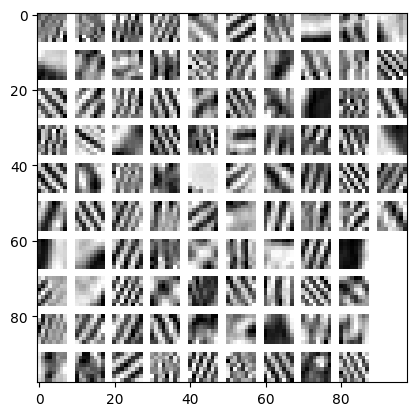

In [213]:
img_dict = get_dictionary_img(D)
plt.figure()
plt.imshow(img_dict, cmap='gray')


Denoising via $\ell^1$ sparse coding (use a dictionary learned by KSVD)
------------------------------------
Set the noise level and add the noise to the original image

In [214]:
sigma_noise = 20/255
noisy_img = img + np.random.normal(size=imsz) * sigma_noise


Compue the psnr of the noisy input

In [215]:
def psnr(img1, img2, max_pixel=1.0):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 10 * np.log10(max_pixel ** 2 / mse)

In [216]:
psnr_noisy = psnr(img, noisy_img)


Text(0.5, 1.0, 'Noisy image, PSNR = 22.10')

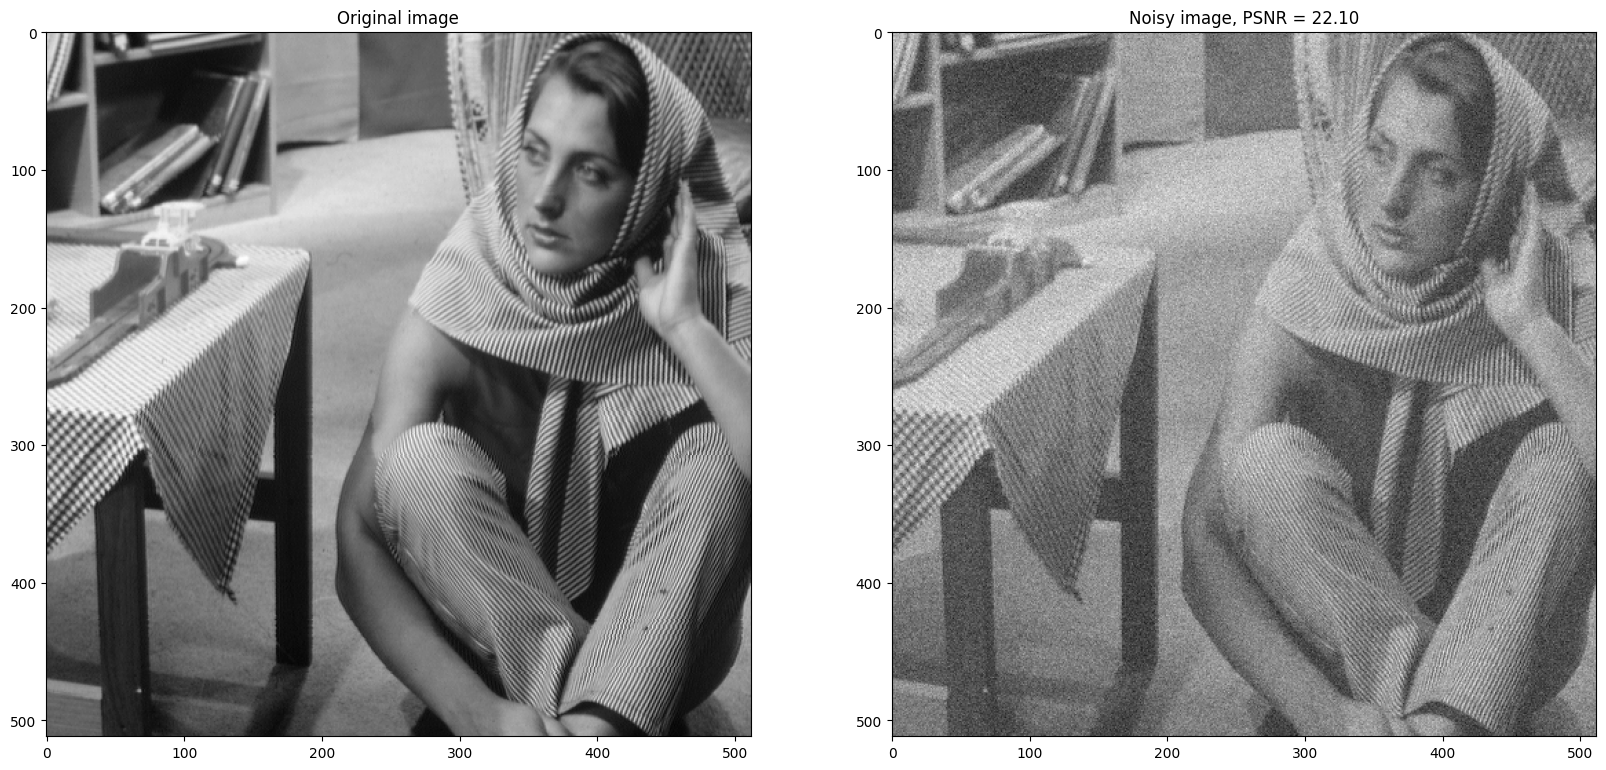

In [217]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(noisy_img, cmap='gray')
ax[1].set_title(f'Noisy image, PSNR = {psnr_noisy:.2f}')

Use the dictionary computed with the MOD or load a pretrained dictionary $D$

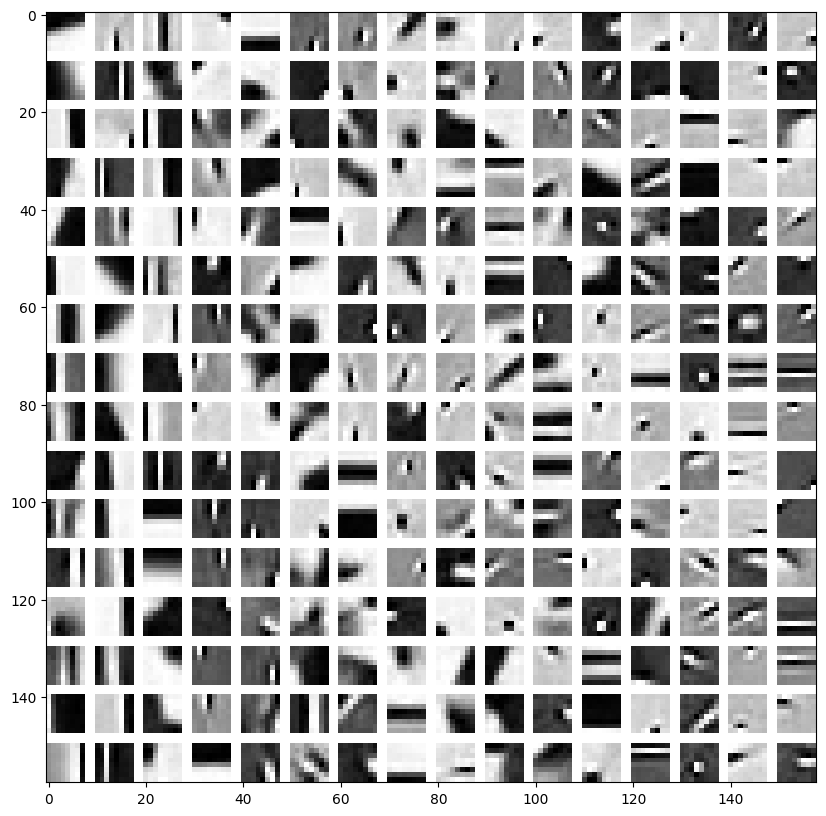

In [218]:
D = loadmat(f'{rootfolder}/data/dict_nat_img.mat')['D']

# show the dictionary
D_img = get_dictionary_img(D)
plt.figure(figsize=(10,10))
plt.imshow(D_img, cmap='gray')


In [219]:
# initialize the estimated image
img_hat = np.zeros_like(img)

# initialize the weight matrix
weights = np.zeros_like(img)

# set the threshold
tau = 2.2
lmbda = tau * sigma_noise

# define the step (=p for non overlapping paches)
STEP = 4 # STEP = 1 might be very time consuming, start with larger STEP

Operate patchwise

In [ ]:
for i in range(0, imsz[0] - p + 1, STEP):
    for j in range(0, imsz[1] - p + 1, STEP):
        # extrach the patch with the top left corner at pixel (ii, jj)
        s = noisy_img[i : i + p, j : j + p].flatten()

        # store and subtract the mean
        s_mean = np.mean(s)
        s_debias = s - s_mean

        # perform the sparse coding of the patch s to compute the coefficients vector x
        x = IRLS(s_debias, D, lmbda)

        # perform the reconstruction
        s_hat = D @ x

        w = 1

        # add back the mean
        s_hat = s_hat + s_mean

        # put the denoised patch into the estimated image using uniform weights
        img_hat[i : i + p, j : j + p] += s_hat.reshape(p, p)

        # store the weight of the current patch in the weight matrix
        weights[i : i + p, j : j + p] += 1

[-0.0085224  -0.05588764  0.06528631 -0.02679662  0.03992319  0.04429245
  0.11538109  0.19223757 -0.11439451 -0.00435443 -0.00398915 -0.08258881
  0.17192187 -0.22315028  0.00156714  0.1122139  -0.15622262  0.08558596
 -0.01305412 -0.02713813 -0.02637475 -0.02959734  0.03728803  0.09331419
 -0.1315938  -0.12405726 -0.10646571 -0.10498411 -0.07237637 -0.04712389
 -0.01357355  0.06747854  0.01594532  0.09125747  0.01380133 -0.06909234
  0.06334031 -0.17379681  0.06241366  0.04511158  0.0716378   0.1562826
  0.03632068  0.03741822  0.02854517 -0.06359282 -0.00994373 -0.00228922
 -0.07090564 -0.05081777 -0.08554347 -0.03096273 -0.06447953 -0.02320552
  0.15883417  0.11842122  0.08022957  0.12110069 -0.15019021  0.04968211
 -0.0208363   0.03028828 -0.11052766  0.09130879]
[ 5.93553007e-07  3.49392413e-05 -3.31205437e-06  6.02503699e-06
 -1.11839046e-06  2.45212760e-07  3.37168199e-06 -1.35917901e-06
 -1.77942950e-05  1.98178342e-05  2.54325370e-06 -7.24718290e-07
  4.15679652e-07  1.999500

Normalize the estimated image with the computed weights

In [ ]:
img_hat = img_hat / weights

Compute the psnr of the estimated image

Text(0.5, 1.0, 'Estimated Image,\nPSNR = 22.01')

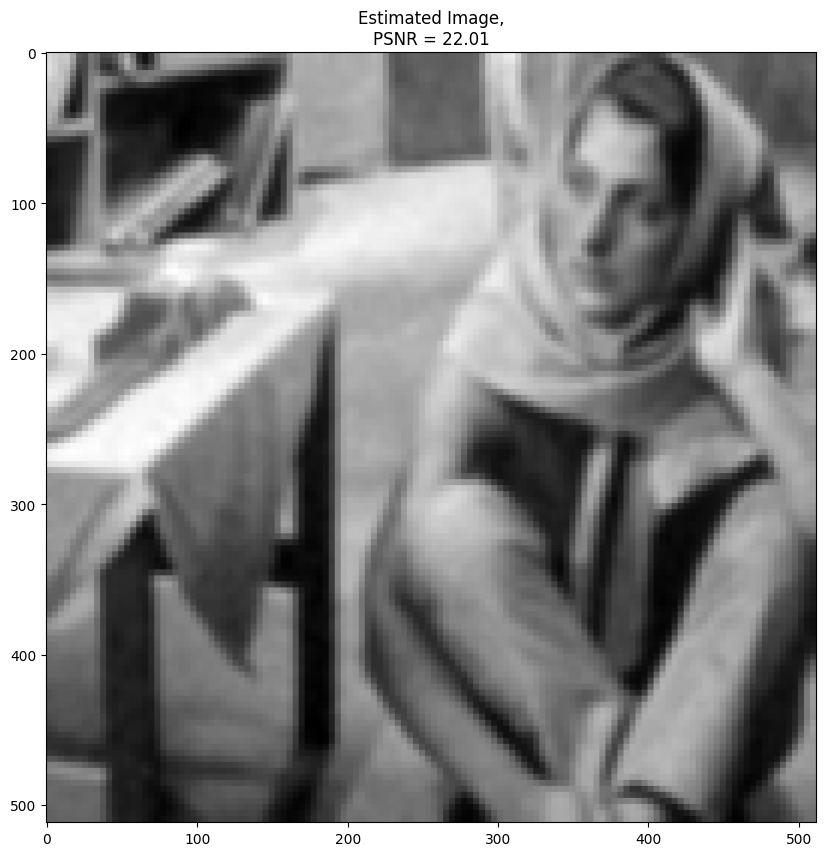

In [ ]:
psnr_hat = 10*np.log10(1 / np.mean((img - img_hat) ** 2))
plt.figure(figsize=(10,10))
plt.imshow(img_hat, cmap='gray')
plt.title(f'Estimated Image,\nPSNR = {psnr_hat:.2f}')
